## 平均ギアパワー（ルール別）

In [1]:
import re
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 1)
date_to = dt.date(2023, 6, 27)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
players = u.to_players(battles, append_abilities=True)

In [2]:
ability_cols = [x for x in players.columns if re.compile("^ability-.+").match(x)]
ability_cols = [x for x in ability_cols if x != "ability-ability_doubler"]

In [3]:
ability_mean = players.groupby(["mode", "weapon"])[ability_cols].mean()
ability_mean = ability_mean.rename(columns=lambda x: re.sub("^ability-", "mean-", x))
ability_mean

mean-ink_saver_main  mean-ink_saver_sub  \
mode   weapon                                                        
area   52gal                          0.181698            0.157384   
       96gal                          0.445455            0.179221   
       96gal_deco                     0.281954            0.203642   
       bamboo14mk1                    0.673913            0.339130   
       barrelspinner                  0.161746            0.041377   
...                                        ...                 ...   
yagura tristringer                    0.691791            0.231237   
       variableroller                 0.513854            0.101259   
       wakaba                         0.128177            2.300949   
       wideroller                     0.754839            0.490323   
       wideroller_collabo             0.573054            0.653293   

                           mean-ink_recovery_up  mean-run_speed_up  \
mode   weapon                                                        
area   52gal                           0.132437           0.157700   
       96gal                           0.232468           0.158442   
       96gal_deco                      0.208609           0.050993   
       bamboo14mk1                     0.255072           0.661353   
       barrelspinner                   0.078566           2.919375   
...                                         ...                ...   
yagura tristringer                     0.255011           0.667910   
       variableroller                  0.141310           0.111083   
       wakaba                          0.345380           0.089356   
       wideroller                      0.483871           0.180645   
       wideroller_collabo              0.317365           0.091617   

                           mean-swim_speed_up  mean-special_charge_up  \
mode   weapon                                                           
area   52gal                         1.539293                0.222890   
       96gal                         1.019481                0.351948   
       96gal_deco                    0.995364                0.643212   
       bamboo14mk1                   0.712560                0.611594   
       barrelspinner                 0.280483                0.280341   
...                                       ...                     ...   
yagura tristringer                   0.637420                0.810768   
       variableroller                1.041310                1.250378   
       wakaba                        0.561221                0.429744   
       wideroller                    0.787097                0.748387   
       wideroller_collabo            0.788024                0.704790   

                           mean-special_saver  mean-special_power_up  \
mode   weapon                                                          
area   52gal                         0.146888               0.093987   
       96gal                         0.118182               0.240260   
       96gal_deco                    0.177152               0.657119   
       bamboo14mk1                   0.184541               0.213043   
       barrelspinner                 0.070617               0.126260   
...                                       ...                    ...   
yagura tristringer                   0.138273               0.197548   
       variableroller                0.219018               0.188791   
       wakaba                        0.132632               0.052723   
       wideroller                    0.129032               0.229032   
       wideroller_collabo            0.156287               0.070659   

                           mean-quick_respawn  mean-quick_super_jump  ...  \
mode   weapon                                                         ...   
area   52gal                         0.322890               0.284335  ...   
       96gal                         0.123377               0.248052  ...   
       96g

In [4]:
from packages.master import Master, load_master

main = load_master(Master.MAIN_WEAPON)

In [5]:
def show_gear_point_averages(mode: str):
    sns.set_theme()
    japanize()

    df = pd.concat([main[["type-key"]], ability_mean.loc[mode]], axis=1).rename(columns=lambda x: re.sub("mean-", "", x)).reindex(index=d.WEAPON_ORDER)


    i18n = Translator(locale)
    i18n.add("title", "${lobby} ${mode} 平均ギアパワー（5.7表記）", "Ability point averages in ${mode} ${lobby}")

    vmax = ability_mean.max().max()

    fig, axes = plt.subplots(
        figsize=(15, len(df.index) * 0.6),
        nrows=len(d.TYPE_ORDER),
        gridspec_kw={
            "height_ratios": [len(df[df["type-key"] == x]) for x in d.TYPE_ORDER],
            "hspace": .14,
        },
    )

    fig.suptitle(
        i18n.t("title", lobby=i18n.t(lobby.value), mode=i18n.t(mode)),
        verticalalignment="bottom",
        y=0.89,
    )

    for i, weapon_type in enumerate(d.TYPE_ORDER):
        ax = axes[i]
        sns.heatmap(
            data=df[df["type-key"] == weapon_type].drop(columns="type-key"),
            square=True,
            annot=True,
            fmt=".1f",
            cbar=False,
            cmap=sns.color_palette("ch:start=.6,rot=.3,gamma=.8,light=.92", as_cmap=True),
            linewidths=2,
            vmin=0,
            vmax=vmax,
            ax=ax,
        )

        xkeys, ykeys = u.get_ax_ticklabels(ax)
        xticklabels = [i18n.t(x) for x in xkeys]
        yticklabels = [i18n.t(x) for x in ykeys]

        ax.set(
            xlabel="",
            ylabel="",
            xticklabels="",
        )
        ax.yaxis.set_ticklabels(yticklabels, x=-0.032)

        for i, key in enumerate(ykeys):
            image_path = image.get_image_path(key)
            img = OffsetImage(plt.imread(image_path), zoom=.65)
            img.image.axes = ax
            ab = AnnotationBbox(img, (0, 0), xybox=(-0.55, i + 0.5), frameon=False)
            ax.add_artist(ab)

        for i, key in enumerate(xkeys):
            image_path = image.get_image_path(key)
            img = OffsetImage(plt.imread(image_path), zoom=.65)
            img.image.axes = ax
            ab = AnnotationBbox(img, (0, 0), xybox=(i + 0.5, -0.5), frameon=False)
            ax.add_artist(ab)

            # background circle
            width = 0.7
            height = width * 1
            ax.add_patch(patches.Ellipse((i + 0.5, -0.5), width, height, color="#333", clip_on=False))

    u.credit(ax, fig, i18n.t_data_duration(battles), 0.3)

    plt.show()

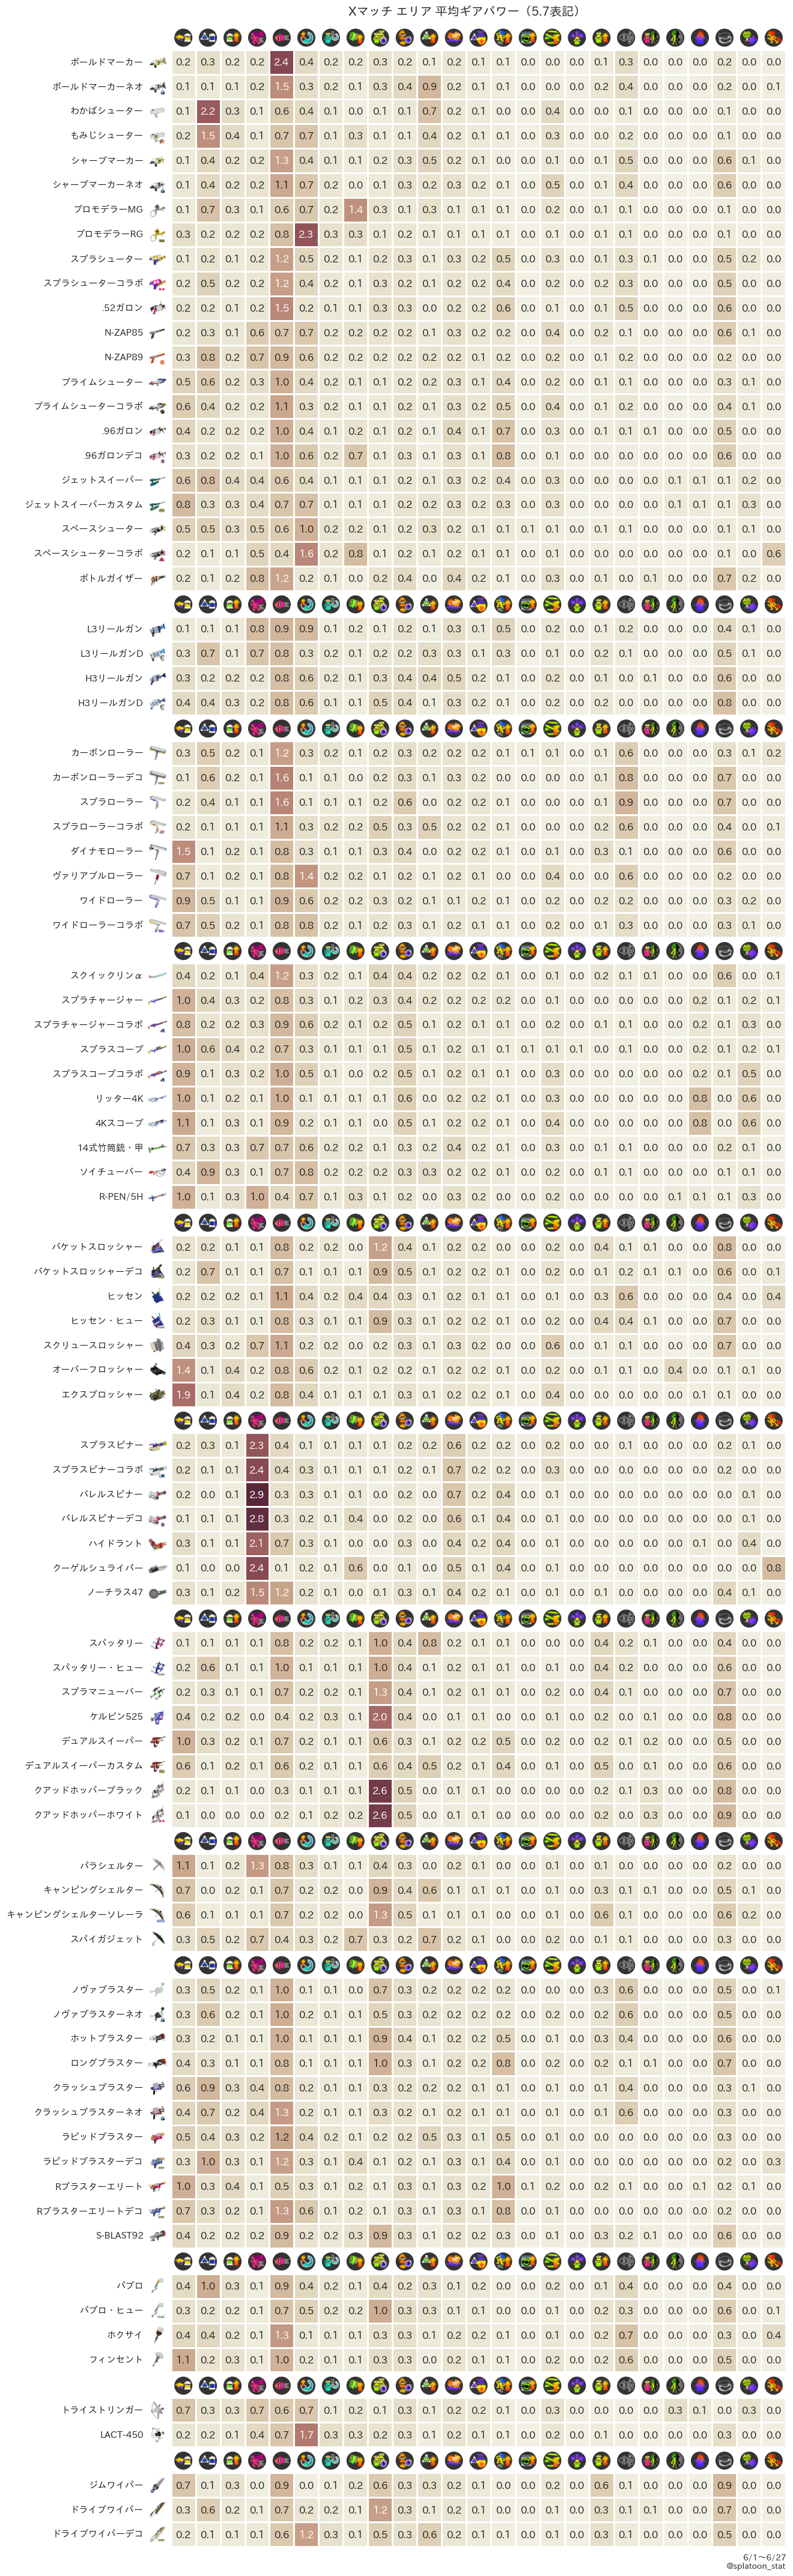

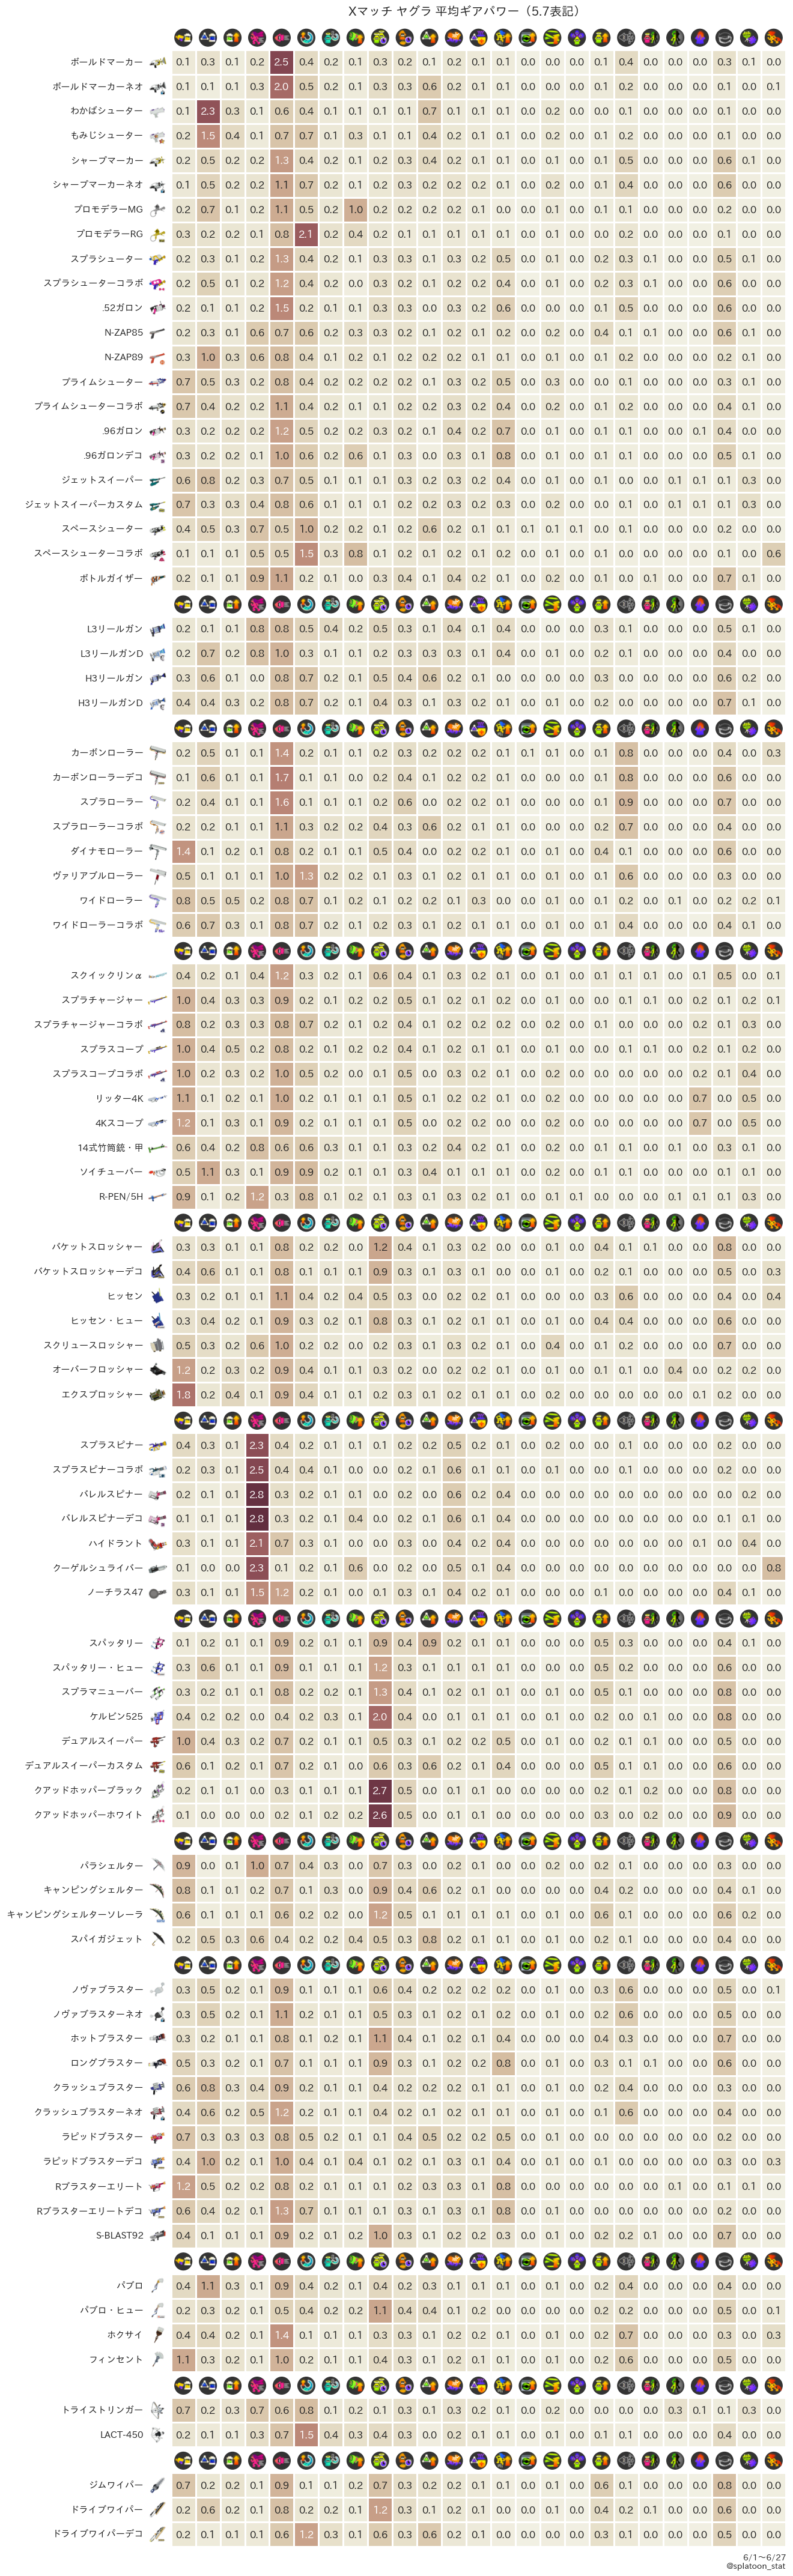

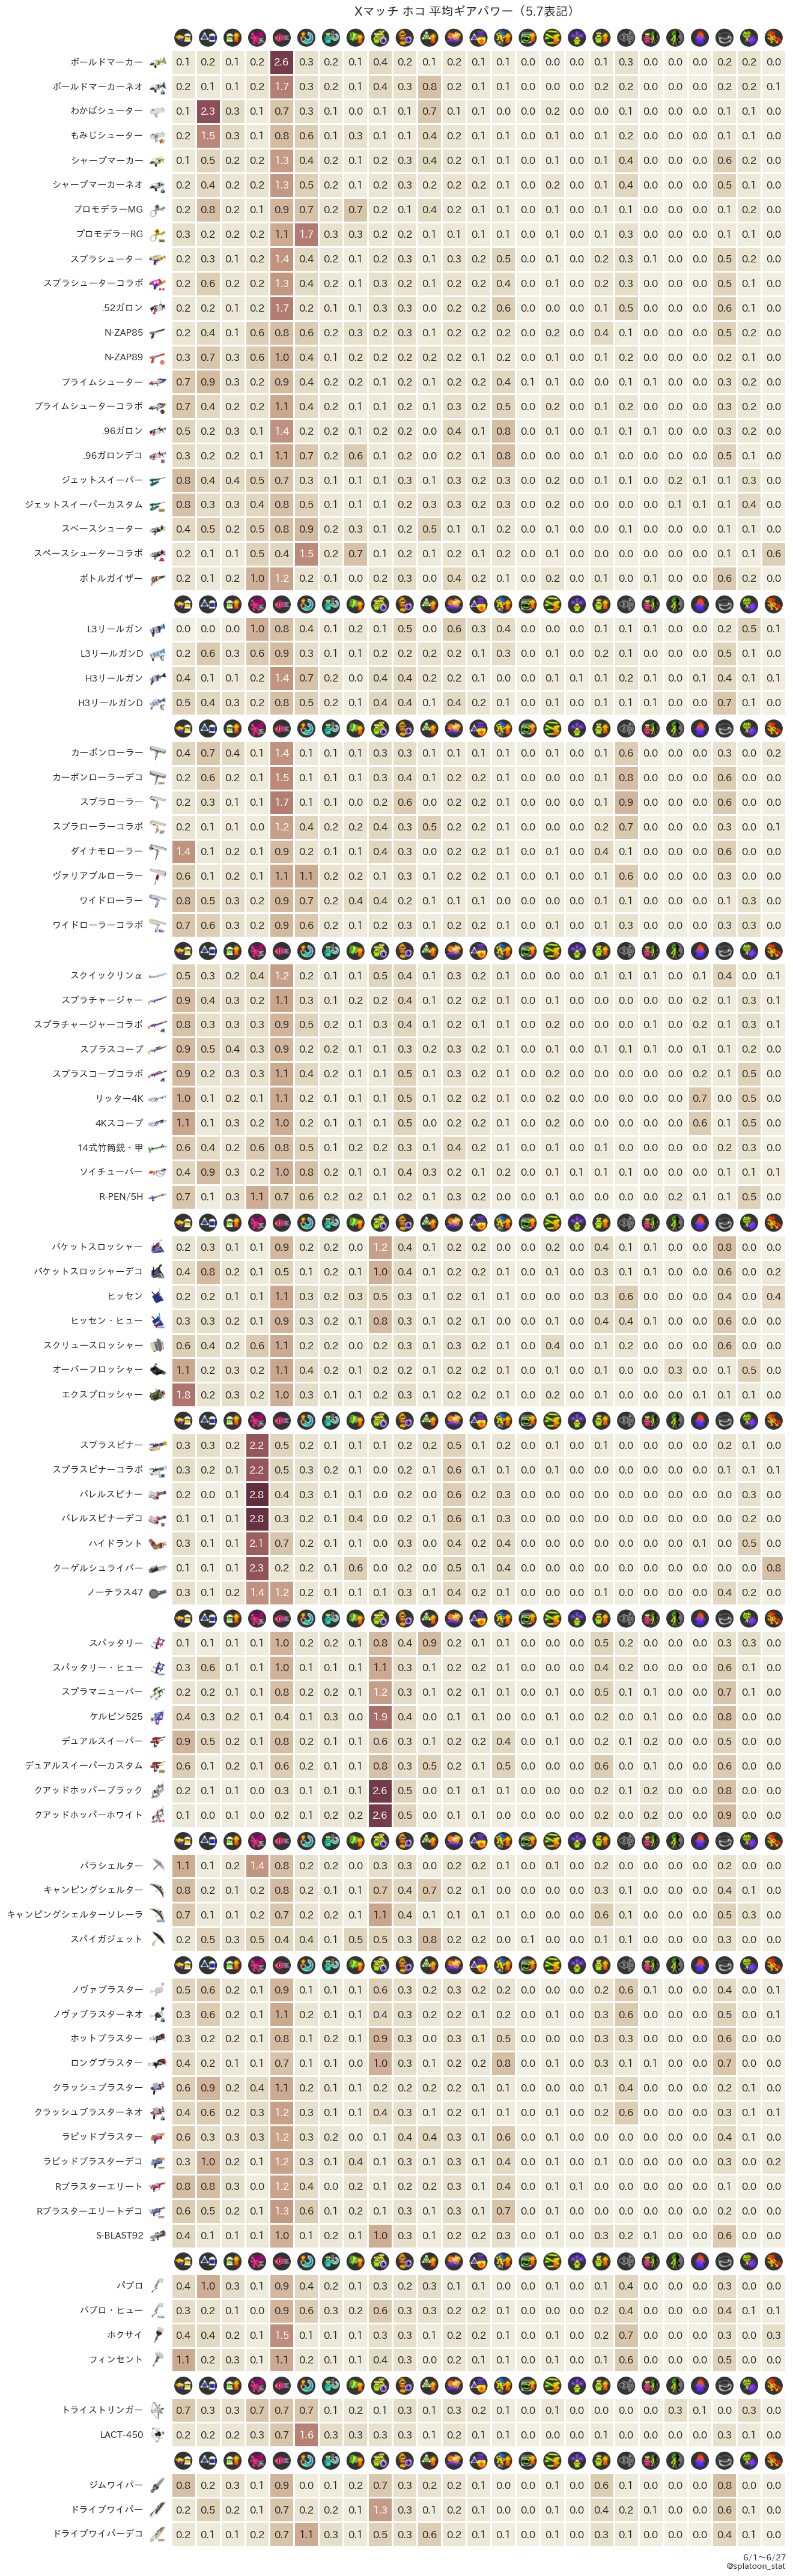

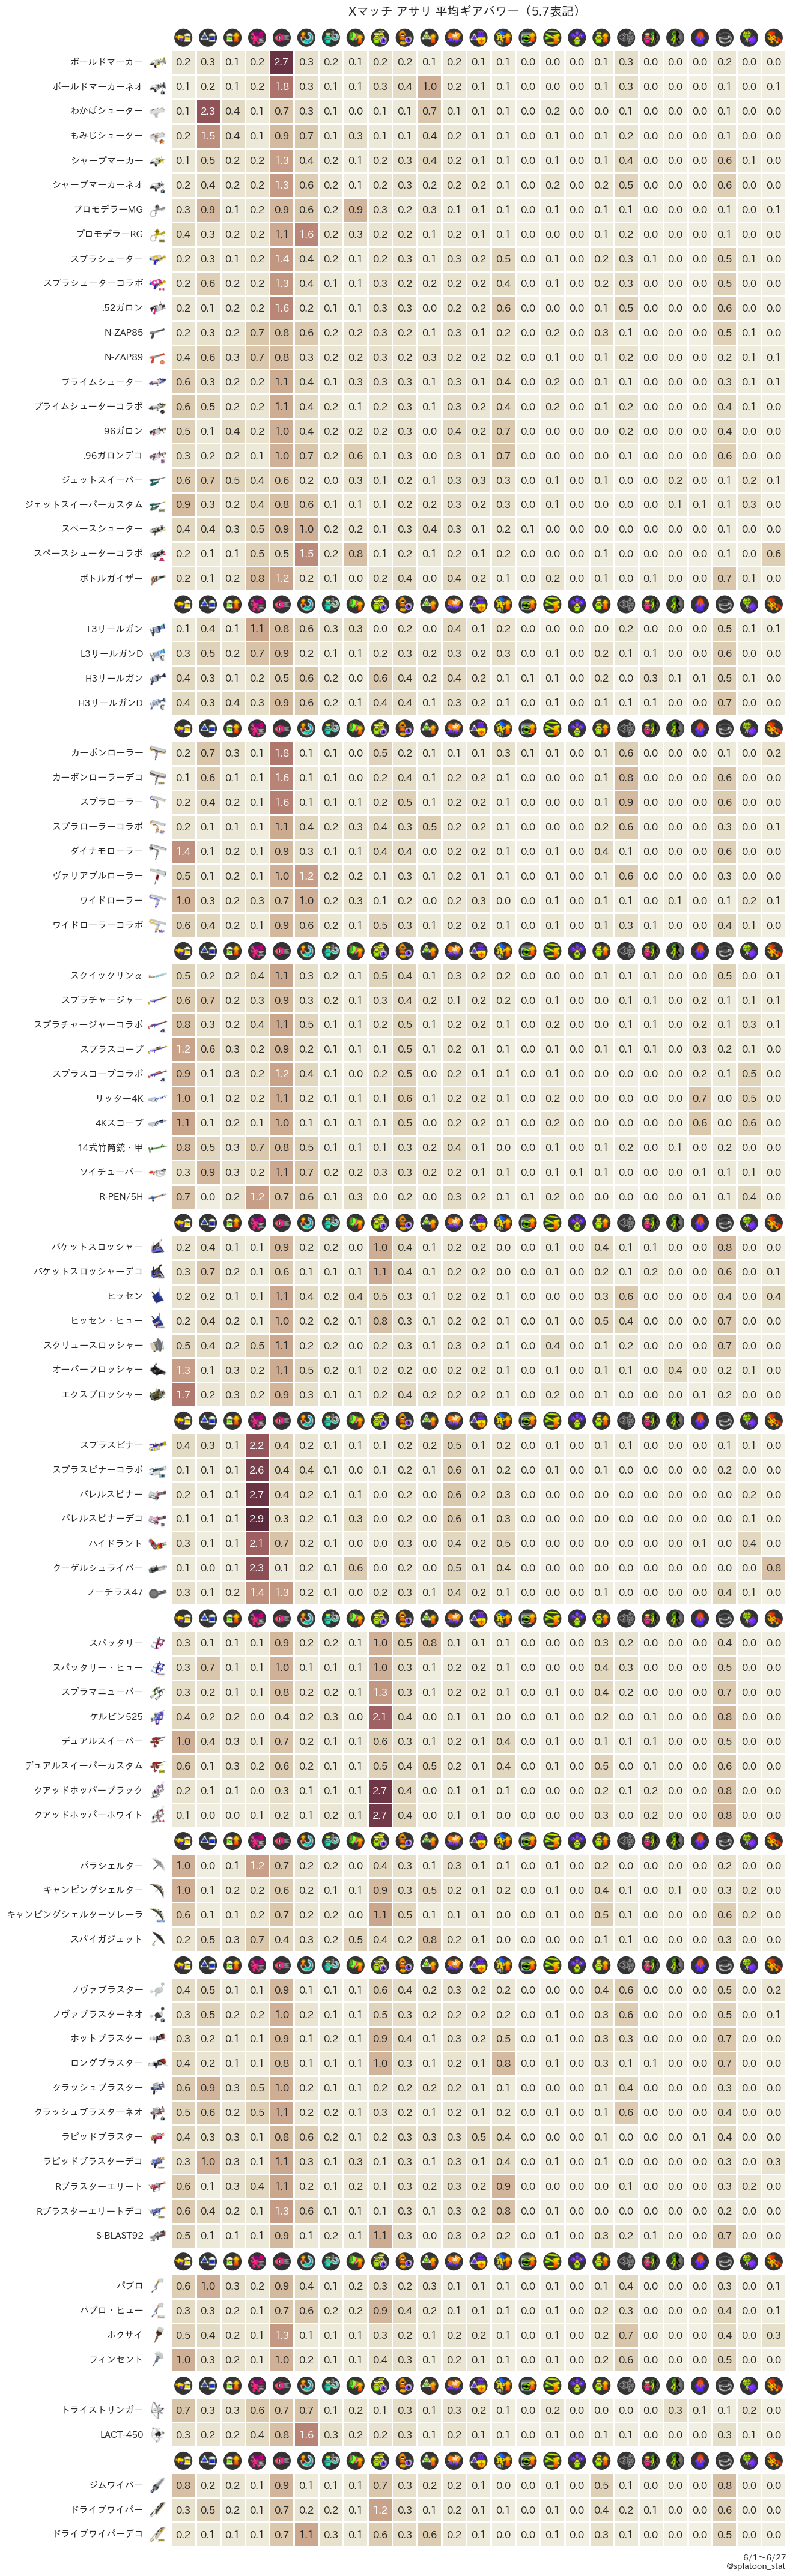

In [6]:
for mode in d.MODE_ORDER:
    show_gear_point_averages(mode)